In [4]:
# import des packages nécessaires à l'exécution du code 

import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

Le modèle choisi est le modèle de régression linéaire Lasso. 

La régression linéaire offrait des scores plus élevés et Lasso permettait de réduire l'overfitting : la régression linéaire classique donnait des prédictions aberrantes dès que les valeurs s'éloignaient trop du jeu de test. 

Les valeurs extrêmes sont conservées afin d'offrir un modèle plus inclusif.

D'autres modèles offraient un score plus important mais contenaient des features qu'il paraissait difficile de demander à un utilisateur, comme la surface habitable moyenne de ses 15 plus proches voisins. 

Le OneHotEncoder et le Polynomial Features ont permis d'augmenter significativement le score du modèle.
Le RobustScaler a été retenu à la place du classique MinMaxScaler car, malgré un score équivalent, il tient compte des valeurs extrêmes présentes dans le jeu de données.

## Modèle 8 - Régression linéaire Lasso, avec valeurs extrêmes, sans valeurs qu'on ne peut pas demander aux utilisateurs

Ce modèle sera celui qui contient les valeurs extrêmes : moins précis mais moins restrictif. Les features sont : 
- les différentes surfaces (m2_living, m2_above,m2_basement,m2_lot)
- le nombre de pièces (bedrooms,bathrooms) et d'étages (floors)
- les années de construction, rénovation
- les notes obtenues sur différents sujets (grade,condition,view)
- localisation (zipcode, lat, long, waterfront)

J'ai retiré les features qu'il ne paraît pas logique de demander à un propriétaire, qu'il aurait du mal à connaître.

Preprocessing : 
- RobustScaler
- PolynomialFeature
- OneHotEncoder
- GridSearchCV pour choisir le meilleur hyperparamètre de Lasso (alpha)

In [5]:
df_model = pd.read_csv('data_cleaned.csv')

In [6]:
X = df_model[['m2_living','grade','view','m2_above','bathrooms','zipcode','m2_basement','bedrooms','waterfront','floors','yr_renovated','m2_lot','yr_built','condition']]
y = df_model['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=420)

numeric_features = list(X.drop(['view'],axis=1).select_dtypes(include=['float64','int64']).columns)
catagorical_features = ['zipcode','view']

numeric_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('min_max', RobustScaler())
])

catagorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', catagorical_transformer, catagorical_features)
    ])

param_grid= {'alpha':[0.1,1,10]} 

grid = GridSearchCV(Lasso(), param_grid, cv=5)

grid.fit(X_train, y_train)
regression = grid.best_estimator_


pipe = Pipeline([
    ('prep',preprocessor),
    ('reg',regression)
                
])

/home/apprenant/miniconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.519e+13, tolerance: 1.843e+11
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.437e+13, tolerance: 1.790e+11
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

In [7]:

trained_pipe = pipe.fit(X_train, y_train)
predictions = trained_pipe.predict(X_test)
trained_pipe.score(X_test, y_test)

/home/apprenant/miniconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+14, tolerance: 2.255e+11
  model = cd_fast.enet_coordinate_descent(


0.8788393952319745

Text(0.5, 1.0, 'Comparaison des prédictions avec les données du jeu de test')

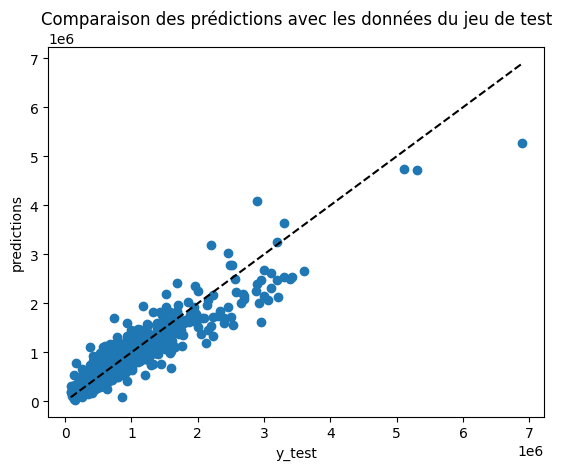

In [8]:
plt.scatter(y_test,predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('y_test')
plt.ylabel('predictions')
plt.title('Comparaison des prédictions avec les données du jeu de test')

In [9]:
## Sauvegarde avec pickle
with open('model.pickle','wb') as f: 
    pickle.dump(trained_pipe,f)